In [3]:
# ============================================================
# INSTALACIÓN DE LIBRERÍAS PARA COMPARACIÓN DEEPSPEED
# ============================================================

# 🔥 LIBRERÍAS ESENCIALES (obligatorias)
%pip install transformers  # Para modelos y tokenizers
%pip install datasets      # Para manejo de datasets
%pip install deepspeed    # ⭐ La estrella del show!
%pip install huggingface_hub   # Para manejo de datasets y modelos
%pip install google-generativeai

# 🛠️ LIBRERÍAS DE SOPORTE (recomendadas)
%pip install accelerate    # Facilita integración con DeepSpeed
%pip install trl           # Para Supervised Fine-Tuning (SFT)

# 📊 MONITOREO Y VISUALIZACIÓN
%pip install psutil        # Monitor de CPU/RAM
%pip install GPUtil        # Monitor de GPU
%pip install matplotlib    # Gráficos
%pip install seaborn      # Gráficos bonitos
%pip install pandas       # Tablas de datos
%pip install numpy        # Operaciones numéricas



In [4]:
from transformers import (
    AutoTokenizer,
    # AutoModelForCausalLM, # Moved to fe80618d
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import Dataset
from trl import SFTTrainer
import deepspeed
import time
import psutil
import GPUtil
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import os
import gc
import warnings
warnings.filterwarnings('ignore')

# Configurar para mostrar gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

[2025-07-23 22:22:31,988] [WARNING] [real_accelerator.py:209:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
[2025-07-23 22:22:31,992] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cpu (auto detect)
[2025-07-23 22:22:35,540] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [5]:
class PerformanceMonitor:
    """Clase para monitorear rendimiento durante el entrenamiento"""

    def __init__(self):
        self.metrics = {
            'gpu_memory_used': [],
            'gpu_utilization': [],
            'cpu_percent': [],
            'ram_used': [],
            'timestamps': []
        }

    def start_monitoring(self):
        """Inicia el monitoreo de recursos"""
        self.start_time = time.time()

    def log_metrics(self):
        """Registra métricas actuales del sistema"""
        # GPU metrics
        if torch.cuda.is_available():
            gpu = GPUtil.getGPUs()[0] if GPUtil.getGPUs() else None
            if gpu:
                self.metrics['gpu_memory_used'].append(gpu.memoryUsed)
                self.metrics['gpu_utilization'].append(gpu.load * 100)
            else:
                self.metrics['gpu_memory_used'].append(0)
                self.metrics['gpu_utilization'].append(0)
        else:
            self.metrics['gpu_memory_used'].append(0)
            self.metrics['gpu_utilization'].append(0)

        # CPU y RAM
        self.metrics['cpu_percent'].append(psutil.cpu_percent())
        self.metrics['ram_used'].append(psutil.virtual_memory().used / (1024**3))  # GB
        self.metrics['timestamps'].append(time.time() - self.start_time)

    def get_average_metrics(self):
        """Calcula métricas promedio"""
        return {
            'avg_gpu_memory': np.mean(self.metrics['gpu_memory_used']) if self.metrics['gpu_memory_used'] else 0,
            'avg_gpu_utilization': np.mean(self.metrics['gpu_utilization']) if self.metrics['gpu_utilization'] else 0,
            'avg_cpu_percent': np.mean(self.metrics['cpu_percent']) if self.metrics['cpu_percent'] else 0,
            'avg_ram_used': np.mean(self.metrics['ram_used']) if self.metrics['ram_used'] else 0,
            'total_time': self.metrics['timestamps'][-1] if self.metrics['timestamps'] else 0
        }

def print_system_info():
    """Muestra información del sistema"""
    print("🖥️ INFORMACIÓN DEL SISTEMA")
    print("=" * 50)
    print(f"🐍 Python: {torch.__version__}")
    print(f"🔥 PyTorch: {torch.__version__}")
    print(f"🚀 CUDA disponible: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"📊 GPU: {torch.cuda.get_device_name(0)}")
        print(f"🎯 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"💾 RAM total: {psutil.virtual_memory().total / (1024**3):.1f} GB")
    print(f"🔄 CPUs: {psutil.cpu_count()}")
    print("=" * 50)


In [13]:
# ============================================================
# 📊 CREACIÓN DE DATASET SFT CON GEMINI - VERSIÓN CORREGIDA
# ============================================================

# Instalar dependencias necesarias
%pip install google-generativeai datasets pandas

import google.generativeai as genai
import random
import json
import pandas as pd
from datasets import Dataset
import numpy as np
import os
from datetime import datetime
import time

# ⚠️ CONFIGURAR API KEY DE GEMINI
# Opción 1: Usar tu API key directamente (RÁPIDO PARA TESTING)
GEMINI_API_KEY = 'apikey'  # Reemplaza con tu clave real

# Opción 2: Usar Colab Secrets (MÁS SEGURO)
# Descomenta las siguientes líneas si prefieres usar secrets:
"""
try:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    print("✅ API Key obtenida desde Colab Secrets")
except Exception as e:
    print(f"❌ Error al obtener de Secrets: {e}")
    GEMINI_API_KEY = None
"""

# Validar API key
if not GEMINI_API_KEY or GEMINI_API_KEY in ['YOUR_GEMINI_API_KEY_HERE', 'TU_API_KEY_AQUI']:
    print("❌ Por favor, reemplaza 'GEMINI_API_KEY' con tu clave real")
    print("🔗 Obtén tu key en: https://aistudio.google.com/app/apikey")
    model = None
else:
    try:
        # Configurar Gemini
        genai.configure(api_key=GEMINI_API_KEY)

        # Crear modelo con configuración optimizada
        model = genai.GenerativeModel(
            'gemini-1.5-flash-latest',
            generation_config=genai.GenerationConfig(
                temperature=0.9,
                top_p=0.95,
                max_output_tokens=800,
                candidate_count=1
            )
        )

        # Hacer una prueba rápida para verificar que funciona
        test_response = model.generate_content("Di solo 'OK' si puedes responder")
        if test_response.text:
            print("✅ Gemini configurado y funcionando correctamente")
            print(f"🔑 API Key válida (termina en: ...{GEMINI_API_KEY[-6:]})")
        else:
            print("⚠️ Modelo configurado pero respuesta vacía")

    except Exception as e:
        print(f"❌ Error configurando Gemini: {str(e)}")
        print("💡 Verifica que tu API key sea correcta y tenga permisos")
        model = None

def create_sft_dataset_with_gemini(num_samples=100, delay_between_requests=1):
    """
    Crea un dataset sintético de alta calidad usando Gemini
    para Supervised Fine-Tuning (SFT) de modelos de 3B parámetros.

    Args:
        num_samples (int): Número total de muestras a generar
        delay_between_requests (float): Delay en segundos entre requests para evitar rate limits

    Returns:
        Dataset: Dataset de Hugging Face con las conversaciones generadas
    """
    if not model:
        print("❌ Modelo Gemini no configurado. Revisa tu API key.")
        return Dataset.from_list([])

    # Categorías optimizadas para modelos de 3B
    sft_categories = [
        {
            "category": "conversacion_general",
            "weight": 0.25,
            "prompt": """Genera una conversación natural donde un usuario hace una pregunta cotidiana
            y el asistente responde de manera útil y amigable. La respuesta debe ser concisa pero completa.

            Ejemplos de temas: hobbies, consejos prácticos, explicaciones simples, recomendaciones.

            Formato exacto:
            Usuario: [pregunta natural y específica]
            Asistente: [respuesta útil de 50-150 palabras]"""
        },
        {
            "category": "ayuda_tecnica",
            "weight": 0.20,
            "prompt": """Genera una conversación donde el usuario pide ayuda técnica básica
            y el asistente da una solución clara y paso a paso.

            Ejemplos: programación básica, uso de software, troubleshooting simple.

            Formato exacto:
            Usuario: [problema técnico específico]
            Asistente: [solución paso a paso de 100-200 palabras]"""
        },
        {
            "category": "educativo",
            "weight": 0.20,
            "prompt": """Genera una conversación educativa donde el usuario pregunta sobre un concepto
            y el asistente explica de manera clara con ejemplos prácticos.

            Ejemplos: ciencia básica, historia, matemáticas, idiomas.

            Formato exacto:
            Usuario: [pregunta educativa]
            Asistente: [explicación clara con ejemplos de 100-200 palabras]"""
        },
        {
            "category": "creatividad",
            "weight": 0.15,
            "prompt": """Genera una conversación donde el usuario pide ayuda creativa
            y el asistente ofrece ideas originales y útiles.

            Ejemplos: escritura, ideas para proyectos, soluciones creativas.

            Formato exacto:
            Usuario: [solicitud creativa]
            Asistente: [respuesta creativa e inspiradora de 80-180 palabras]"""
        },
        {
            "category": "etica_seguridad",
            "weight": 0.20,
            "prompt": """Genera una conversación donde el usuario hace una pregunta que requiere
            una respuesta responsable, y el asistente responde éticamente explicando consideraciones importantes.

            Formato exacto:
            Usuario: [pregunta que requiere consideraciones éticas]
            Asistente: [respuesta responsable y educativa de 100-200 palabras]"""
        }
    ]

    dataset_entries = []

    # Calcular muestras por categoría basado en pesos
    samples_distribution = {}
    for cat in sft_categories:
        samples_distribution[cat["category"]] = int(num_samples * cat["weight"])

    # Ajustar para que sume exactamente num_samples
    total_assigned = sum(samples_distribution.values())
    if total_assigned < num_samples:
        # Agregar muestras faltantes a la primera categoría
        first_cat = sft_categories[0]["category"]
        samples_distribution[first_cat] += (num_samples - total_assigned)

    print(f"🎯 Generando {num_samples} muestras distribuidas como:")
    for cat, count in samples_distribution.items():
        print(f"  • {cat}: {count} muestras")

    total_generated = 0

    for category_info in sft_categories:
        category = category_info["category"]
        target_samples = samples_distribution[category]

        if target_samples == 0:
            continue

        print(f"\n🔄 Generando categoría: {category} ({target_samples} muestras)")

        category_generated = 0
        attempts = 0
        max_attempts = target_samples * 3  # Máximo 3 intentos por muestra objetivo

        while category_generated < target_samples and attempts < max_attempts:
            attempts += 1

            try:
                # Añadir variación al prompt
                variation_prompt = f"""
                {category_info["prompt"]}

                IMPORTANTE:
                - Genera SOLO UNA conversación
                - Usa un tema específico y diferente cada vez
                - La respuesta del asistente debe ser natural y humana
                - NO incluyas explicaciones adicionales
                - Responde EXACTAMENTE en el formato Usuario:/Asistente:

                Variación #{attempts}: Cambia el tema y contexto específico.
                """

                # Generar con Gemini
                response = model.generate_content(variation_prompt)

                if not response.text:
                    print(f"  ⚠️  Respuesta vacía en intento {attempts}")
                    continue

                generated_text = response.text.strip()

                # Procesar respuesta
                if process_gemini_response(generated_text, category, dataset_entries):
                    category_generated += 1
                    total_generated += 1
                    print(f"  ✅ {category_generated}/{target_samples} - Total: {total_generated}/{num_samples}")
                else:
                    print(f"  ⚠️  Formato incorrecto en intento {attempts}")

                # Delay para evitar rate limits
                if delay_between_requests > 0:
                    time.sleep(delay_between_requests)

            except Exception as e:
                error_msg = str(e)
                print(f"  ❌ Error en intento {attempts}: {error_msg}")

                if "quota" in error_msg.lower() or "rate" in error_msg.lower():
                    print("  ⏸️  Rate limit detectado, esperando 10 segundos...")
                    time.sleep(10)
                elif "blocked" in error_msg.lower():
                    print("  🚫 Contenido bloqueado, intentando con otro tema...")
                    continue
                else:
                    time.sleep(2)  # Pausa corta para otros errores

    print(f"\n📦 Dataset creado con {len(dataset_entries)} muestras válidas")
    return Dataset.from_list(dataset_entries)

def _process_gemini_response(self, generated_text, category, dataset_entries):
    """Procesa la respuesta de Gemini y la añade al dataset si es válida"""
    try:
        # Buscar patrones Usuario:/Asistente:
        lines = generated_text.split('\n')
        user_text = None
        assistant_text = None

        for i, line in enumerate(lines):
            line = line.strip()
            if line.startswith('Usuario:'):
                user_text = line[8:].strip()
            elif line.startswith('Asistente:'):
                # Tomar todo lo que sigue como respuesta del asistente
                assistant_lines = [line[10:].strip()]
                for j in range(i+1, len(lines)):
                    if not lines[j].strip().startswith('Usuario:'):
                        assistant_lines.append(lines[j].strip())
                    else:
                        break
                assistant_text = ' '.join(assistant_lines).strip()
                break

        # Validar que tenemos ambas partes
        if not user_text or not assistant_text:
            return False

        # Validar longitudes mínimas
        if len(user_text) < 10 or len(assistant_text) < 30:
            return False

        # Crear entrada en formato estándar para SFT
        conversation = f"<|user|>\n{user_text}\n<|assistant|>\n{assistant_text}<|end|>"

        dataset_entries.append({
            "text": conversation,
            "category": category,
            "user_message": user_text,
            "assistant_message": assistant_text,
            "length": len(conversation),
            "tokens_estimate": len(conversation.split()),
            "created_at": datetime.now().isoformat()
        })

        return True

    except Exception as e:
        print(f"    ❌ Error procesando respuesta: {e}")
        return False

# Corregir el método como función independiente
def process_gemini_response(generated_text, category, dataset_entries):
    """Procesa la respuesta de Gemini y la añade al dataset si es válida"""
    try:
        # Buscar patrones Usuario:/Asistente:
        lines = generated_text.split('\n')
        user_text = None
        assistant_text = None

        for i, line in enumerate(lines):
            line = line.strip()
            if line.startswith('Usuario:'):
                user_text = line[8:].strip()
            elif line.startswith('Asistente:'):
                # Tomar todo lo que sigue como respuesta del asistente
                assistant_lines = [line[10:].strip()]
                for j in range(i+1, len(lines)):
                    if not lines[j].strip().startswith('Usuario:'):
                        assistant_lines.append(lines[j].strip())
                    else:
                        break
                assistant_text = ' '.join(assistant_lines).strip()
                break

        # Validar que tenemos ambas partes
        if not user_text or not assistant_text:
            return False

        # Validar longitudes mínimas
        if len(user_text) < 10 or len(assistant_text) < 30:
            return False

        # Crear entrada en formato estándar para SFT
        conversation = f"<|user|>\n{user_text}\n<|assistant|>\n{assistant_text}<|end|>"

        dataset_entries.append({
            "text": conversation,
            "category": category,
            "user_message": user_text,
            "assistant_message": assistant_text,
            "length": len(conversation),
            "tokens_estimate": len(conversation.split()),
            "created_at": datetime.now().isoformat()
        })

        return True

    except Exception as e:
        print(f"    ❌ Error procesando respuesta: {e}")
        return False

def show_dataset_stats(dataset):
    """Muestra estadísticas detalladas del dataset"""
    print("\n📈 ESTADÍSTICAS DEL DATASET SFT")
    print("=" * 60)

    if len(dataset) == 0:
        print("❌ Dataset vacío")
        return

    # Estadísticas básicas
    lengths = [item['length'] for item in dataset]
    tokens = [item['tokens_estimate'] for item in dataset]

    print(f"📊 Total de muestras: {len(dataset)}")
    print(f"📏 Longitud promedio: {np.mean(lengths):.1f} caracteres")
    print(f"📏 Longitud mediana: {np.median(lengths):.1f} caracteres")
    print(f"🎯 Tokens promedio: {np.mean(tokens):.1f}")
    print(f"🎯 Tokens mediana: {np.median(tokens):.1f}")

    # Distribución por categorías
    if 'category' in dataset.column_names:
        categories = {}
        for item in dataset:
            cat = item['category']
            categories[cat] = categories.get(cat, 0) + 1

        print("\n🏷️  DISTRIBUCIÓN POR CATEGORÍAS:")
        for cat, count in sorted(categories.items()):
            percentage = (count / len(dataset)) * 100
            print(f"  • {cat}: {count} muestras ({percentage:.1f}%)")

    # Ejemplo de conversación
    print("\n📝 EJEMPLO DE CONVERSACIÓN GENERADA:")
    print("-" * 60)
    example = dataset[0]['text']
    print(example)
    print("-" * 60)

def save_dataset_locally(dataset, base_dir="./sft_dataset"):
    """
    Guarda el dataset localmente en múltiples formatos

    Args:
        dataset: Dataset de Hugging Face
        base_dir: Directorio base donde guardar
    """
    if len(dataset) == 0:
        print("⚠️  Dataset vacío, no se guardará")
        return

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"{base_dir}_{timestamp}"

    try:
        # Crear directorio
        os.makedirs(output_dir, exist_ok=True)

        # 1. Guardar en formato Hugging Face Dataset
        dataset.save_to_disk(os.path.join(output_dir, "hf_dataset"))
        print(f"✅ Dataset HF guardado en: {output_dir}/hf_dataset")

        # 2. Guardar como JSON Lines (formato común para fine-tuning)
        jsonl_path = os.path.join(output_dir, "dataset.jsonl")
        with open(jsonl_path, 'w', encoding='utf-8') as f:
            for item in dataset:
                json.dump(item, f, ensure_ascii=False)
                f.write('\n')
        print(f"✅ JSONL guardado en: {jsonl_path}")

        # 3. Guardar como CSV para análisis
        df = dataset.to_pandas()
        csv_path = os.path.join(output_dir, "dataset.csv")
        df.to_csv(csv_path, index=False, encoding='utf-8')
        print(f"✅ CSV guardado en: {csv_path}")

        # 4. Guardar solo el texto para fine-tuning directo
        text_path = os.path.join(output_dir, "conversations.txt")
        with open(text_path, 'w', encoding='utf-8') as f:
            for i, item in enumerate(dataset):
                f.write(f"# Conversación {i+1}\n")
                f.write(item['text'])
                f.write('\n\n' + '='*50 + '\n\n')
        print(f"✅ Texto plano guardado en: {text_path}")

        # 5. Crear archivo de metadatos
        metadata = {
            "total_samples": len(dataset),
            "creation_date": datetime.now().isoformat(),
            "average_length": float(np.mean([item['length'] for item in dataset])),
            "average_tokens": float(np.mean([item['tokens_estimate'] for item in dataset])),
            "categories": {}
        }

        # Agregar distribución de categorías
        for item in dataset:
            cat = item['category']
            metadata["categories"][cat] = metadata["categories"].get(cat, 0) + 1

        metadata_path = os.path.join(output_dir, "metadata.json")
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        print(f"✅ Metadatos guardados en: {metadata_path}")

        print(f"\n🎉 Dataset completo guardado en: {output_dir}")
        print(f"📁 Contiene: HF Dataset, JSONL, CSV, TXT y metadatos")

        return output_dir

    except Exception as e:
        print(f"❌ Error guardando dataset: {e}")
        return None

def load_dataset_from_local(dataset_path):
    """
    Carga un dataset desde disco

    Args:
        dataset_path: Ruta al directorio del dataset o archivo específico

    Returns:
        Dataset: Dataset cargado
    """
    try:
        if os.path.isdir(dataset_path):
            # Si es un directorio, buscar el dataset de HF
            hf_path = os.path.join(dataset_path, "hf_dataset")
            if os.path.exists(hf_path):
                dataset = Dataset.load_from_disk(hf_path)
                print(f"✅ Dataset cargado desde: {hf_path}")
                return dataset

            # Si no, buscar JSONL
            jsonl_path = os.path.join(dataset_path, "dataset.jsonl")
            if os.path.exists(jsonl_path):
                data = []
                with open(jsonl_path, 'r', encoding='utf-8') as f:
                    for line in f:
                        data.append(json.loads(line))
                dataset = Dataset.from_list(data)
                print(f"✅ Dataset cargado desde JSONL: {jsonl_path}")
                return dataset

        elif dataset_path.endswith('.jsonl'):
            # Cargar directamente desde JSONL
            data = []
            with open(dataset_path, 'r', encoding='utf-8') as f:
                for line in f:
                    data.append(json.loads(line))
            dataset = Dataset.from_list(data)
            print(f"✅ Dataset cargado desde: {dataset_path}")
            return dataset

        print(f"❌ No se pudo encontrar dataset en: {dataset_path}")
        return Dataset.from_list([])

    except Exception as e:
        print(f"❌ Error cargando dataset: {e}")
        return Dataset.from_list([])

# 🚀 EJECUCIÓN PRINCIPAL
print("🚀 GENERADOR DE DATASET SFT PARA MODELOS 3B")
print("=" * 60)

if model:
    # Generar dataset
    print("🎯 Iniciando generación...")
    dataset = create_sft_dataset_with_gemini(
        num_samples=50,  # Empezar con 50 para testing
        delay_between_requests=1.5  # 1.5 segundos entre requests
    )

    # Mostrar estadísticas
    show_dataset_stats(dataset)

    # Guardar localmente
    if len(dataset) > 0:
        saved_path = save_dataset_locally(dataset)

        if saved_path:
            print(f"\n🎉 ¡Dataset creado exitosamente!")
            print(f"📍 Ubicación: {saved_path}")
            print(f"📊 {len(dataset)} muestras de alta calidad")

            # Mostrar cómo cargar el dataset
            print(f"\n💡 Para cargar el dataset más tarde:")
            print(f"dataset = load_dataset_from_local('{saved_path}')")
    else:
        print("\n❌ No se pudieron generar muestras. Revisa tu API key y configuración.")
else:
    print("❌ Configuración incompleta. Revisa tu API key de Gemini.")

print("\n✅ Script completado")

✅ Gemini configurado y funcionando correctamente
🔑 API Key válida (termina en: ...KpnitY)
🚀 GENERADOR DE DATASET SFT PARA MODELOS 3B
🎯 Iniciando generación...
🎯 Generando 50 muestras distribuidas como:
  • conversacion_general: 13 muestras
  • ayuda_tecnica: 10 muestras
  • educativo: 10 muestras
  • creatividad: 7 muestras
  • etica_seguridad: 10 muestras

🔄 Generando categoría: conversacion_general (13 muestras)
  ✅ 1/13 - Total: 1/50
  ✅ 2/13 - Total: 2/50
  ✅ 3/13 - Total: 3/50
  ✅ 4/13 - Total: 4/50
  ✅ 5/13 - Total: 5/50
  ✅ 6/13 - Total: 6/50
  ✅ 7/13 - Total: 7/50
  ✅ 8/13 - Total: 8/50
  ✅ 9/13 - Total: 9/50
  ✅ 10/13 - Total: 10/50
  ✅ 11/13 - Total: 11/50
  ✅ 12/13 - Total: 12/50
  ✅ 13/13 - Total: 13/50

🔄 Generando categoría: ayuda_tecnica (10 muestras)
  ✅ 1/10 - Total: 14/50
  ✅ 2/10 - Total: 15/50
  ✅ 3/10 - Total: 16/50
  ✅ 4/10 - Total: 17/50
  ✅ 5/10 - Total: 18/50
  ✅ 6/10 - Total: 19/50
  ✅ 7/10 - Total: 20/50
  ✅ 8/10 - Total: 21/50
  ✅ 9/10 - Total: 22/50
  ✅ 10/

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

✅ Dataset HF guardado en: ./sft_dataset_20250723_223502/hf_dataset
✅ JSONL guardado en: ./sft_dataset_20250723_223502/dataset.jsonl
✅ CSV guardado en: ./sft_dataset_20250723_223502/dataset.csv
✅ Texto plano guardado en: ./sft_dataset_20250723_223502/conversations.txt
✅ Metadatos guardados en: ./sft_dataset_20250723_223502/metadata.json

🎉 Dataset completo guardado en: ./sft_dataset_20250723_223502
📁 Contiene: HF Dataset, JSONL, CSV, TXT y metadatos

🎉 ¡Dataset creado exitosamente!
📍 Ubicación: ./sft_dataset_20250723_223502
📊 50 muestras de alta calidad

💡 Para cargar el dataset más tarde:
dataset = load_dataset_from_local('./sft_dataset_20250723_223502')

✅ Script completado


In [9]:
# ⚠️ WARNING: Pasting your token directly is INSECURE. Use Colab Secrets instead.
# You can get a token from: https://huggingface.co/settings/tokens

HF_TOKEN = "PASTE_YOUR_HF_TOKEN_HERE"

# You can optionally log in programmatically using the token
from huggingface_hub import login

if HF_TOKEN and HF_TOKEN != "PASTE_YOUR_HF_TOKEN_HERE":
    print("Attempting to log in to Hugging Face Hub with explicit token...")
    try:
        login(token=HF_TOKEN)
        print("✅ Logged in to Hugging Face Hub programmatically.")
    except Exception as e:
        print(f"❌ Failed to log in to Hugging Face Hub programmatically: {e}")
        print("💡 Please double-check your token.")
else:
    print("⚠️  Hugging Face token placeholder not replaced or is empty.")
    print("💡 Please replace 'PASTE_YOUR_HF_TOKEN_HERE' with your actual token.")


# Note: After successful login, the tokenizer and model loading in subsequent cells
# should use this authentication.

Attempting to log in to Hugging Face Hub with explicit token...
✅ Logged in to Hugging Face Hub programmatically.


In [12]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM, # Import AutoModelForCausalLM here
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)


# Configuración del modelo
MODEL_NAME = "google/gemma-2b"  # Modelo pequeño para demostración
MAX_LENGTH = 256
BATCH_SIZE = 4
NUM_EPOCHS = 1
LEARNING_RATE = 2e-5

print(f"\n🤖 Configuración del modelo:")
print(f"📦 Modelo: {MODEL_NAME}")
print(f"📏 Longitud máxima: {MAX_LENGTH}")
print(f"🔢 Batch size: {BATCH_SIZE}")
print(f"🔄 Épocas: {NUM_EPOCHS}")
print(f"📈 Learning rate: {LEARNING_RATE}")

# Cargar tokenizer y modelo (usará la autenticación de Hugging Face si se hizo login)
print("\n🔤 Cargando tokenizer y modelo...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Cargar el modelo directamente usando AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

print("✅ Tokenizer y modelo cargados correctamente")


🤖 Configuración del modelo:
📦 Modelo: google/gemma-2b
📏 Longitud máxima: 256
🔢 Batch size: 4
🔄 Épocas: 1
📈 Learning rate: 2e-05

🔤 Cargando tokenizer y modelo...


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ Tokenizer y modelo cargados correctamente


In [14]:
def preprocess_function(examples):
    """Preprocesa los datos para el entrenamiento"""
    # Tokenizar los textos
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    # Para language modeling, labels = input_ids
    tokenized["labels"] = tokenized["input_ids"].clone()

    return tokenized

# Preprocesar dataset
print("🔄 Preprocesando dataset...")
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset.column_names
)

# Dividir en train/test
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"✅ Datos preparados:")
print(f"🎯 Training samples: {len(train_dataset)}")
print(f"📊 Evaluation samples: {len(eval_dataset)}")

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # No masked language modeling para GPT
)


🔄 Preprocesando dataset...


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

✅ Datos preparados:
🎯 Training samples: 45
📊 Evaluation samples: 5


## ⚡ Paso 8: Configuración de DeepSpeed

In [15]:
# Crear configuración de DeepSpeed
deepspeed_config = {
    "train_batch_size": BATCH_SIZE,
    "train_micro_batch_size_per_gpu": BATCH_SIZE,
    "gradient_accumulation_steps": 1,
    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": LEARNING_RATE,
            "betas": [0.9, 0.999],
            "eps": 1e-8,
            "weight_decay": "auto"  # Set to 'auto' to match TrainingArguments
        }
    },
    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": 0,
            "warmup_max_lr": LEARNING_RATE,
            "warmup_num_steps": 50
        }
    },
    "fp16": {
        "enabled": True,
        "loss_scale": 0,
        "initial_scale_power": 16,
        "loss_scale_window": 1000,
        "hysteresis": 2,
        "min_loss_scale": 1
    },
    "zero_optimization": {
        "stage": 2,
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "overlap_comm": True,
        "contiguous_gradients": True
    },
    "gradient_clipping": 1.0,
    "wall_clock_breakdown": False
}

# Guardar configuración
with open("deepspeed_config.json", "w") as f:
    json.dump(deepspeed_config, f, indent=2)

print("⚡ CONFIGURACIÓN DEEPSPEED CREADA")
print("=" * 40)
print("🎯 Optimizaciones habilitadas:")
print("  ✅ FP16 (Half Precision)")
print("  ✅ ZeRO Stage 2 (Optimizer State Partitioning)")
print("  ✅ Gradient Clipping")
print("  ✅ Comunicación Optimizada")
print("  ✅ AdamW Optimizer")
print("  ✅ Warmup Learning Rate Scheduler")
print("=" * 40)

⚡ CONFIGURACIÓN DEEPSPEED CREADA
🎯 Optimizaciones habilitadas:
  ✅ FP16 (Half Precision)
  ✅ ZeRO Stage 2 (Optimizer State Partitioning)
  ✅ Gradient Clipping
  ✅ Comunicación Optimizada
  ✅ AdamW Optimizer
  ✅ Warmup Learning Rate Scheduler


In [18]:
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model, TaskType
from transformers.trainer_callback import TrainerCallback

def train_baseline_model():
    """Entrena el modelo SIN DeepSpeed usando SFTTrainer + LoRA"""

    print("🐌 INICIANDO ENTRENAMIENTO BASELINE (SIN DEEPSPEED)")
    print("=" * 60)


    # Configuración LoRA para PEFT
    peft_config = LoraConfig(
        r=16,                           # Rango de LoRA
        lora_alpha=32,                  # Parámetro de escalado
        lora_dropout=0.05,              # Dropout para regularización
        target_modules="all-linear",    # Aplicar a todas las capas lineales
        modules_to_save=["lm_head", "embed_tokens"],  # Módulos a guardar completos
        task_type=TaskType.CAUSAL_LM,   # Tipo de tarea
        bias="none"                     # No entrenar bias
    )

    # Configuración de entrenamiento SFT
    sft_config = SFTConfig(
        output_dir="./baseline_sft_results",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        warmup_steps=50,
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=50,
        save_steps=100,
        save_total_limit=2,
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        report_to="none",  # Desactivar W&B
        # Configuraciones específicas de SFT
        max_seq_length=MAX_LENGTH,
        packing=False,                  # No empaquetar secuencias para simplicidad
        dataset_text_field="text",      # Campo que contiene el texto
        seed=42
    )

    print("🤖 Cargando modelo base...")
    print(f"📦 Modelo: {MODEL_NAME}")

    # Inicializar monitor de rendimiento
    monitor = PerformanceMonitor()
    monitor.start_monitoring()

    # Crear SFTTrainer (carga el modelo automáticamente)
    trainer = SFTTrainer(
        model=MODEL_NAME,              # Cargar directamente por nombre
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        args=sft_config,
        peft_config=peft_config,       # Configuración LoRA
        data_collator=None,            # SFTTrainer maneja esto automáticamente
    )

    print("✅ SFTTrainer configurado con LoRA")
    print(f"🎯 Parámetros entrenables: {trainer.model.print_trainable_parameters()}")

    # Entrenar
    print("🚀 Iniciando entrenamiento SFT...")
    start_time = time.time()

    # Callback para monitoreo durante entrenamiento
    class MonitoringCallback(TrainerCallback):
        def __init__(self, monitor):
            self.monitor = monitor

        def on_train_begin(self, args, state, control, **kwargs):
            """Called at the beginning of training."""
            pass # No specific action needed at the start

        def on_step_end(self, args, state, control, logs=None, **kwargs):
            self.monitor.log_metrics()

    trainer.add_callback(MonitoringCallback(monitor))

    # ¡Entrenar!
    trainer.train()

    end_time = time.time()
    training_time = end_time - start_time

    # Obtener métricas finales
    final_metrics = monitor.get_average_metrics()
    final_metrics['total_training_time'] = training_time

    print(f"\n✅ Entrenamiento baseline completado en {training_time:.2f} segundos")

    # Guardar el modelo entrenado
    trainer.save_model("./baseline_sft_final")
    print("💾 Modelo baseline guardado en ./baseline_sft_final")

    # Limpiar memoria
    del trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    return final_metrics, monitor.metrics

# ============================================================
# 🚀 PASO 9: ENTRENAMIENTO CON DEEPSPEED
# ============================================================

def train_deepspeed_model():
    """Entrena el modelo CON DeepSpeed usando SFTTrainer + LoRA"""

    print("🚀 INICIANDO ENTRENAMIENTO CON DEEPSPEED")
    print("=" * 60)

    # Limpiar memoria GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    # Misma configuración LoRA (para comparación justa)
    peft_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        target_modules="all-linear",
        modules_to_save=["lm_head", "embed_tokens"],
        task_type=TaskType.CAUSAL_LM,
        bias="none"
    )

    # Configuración SFT con DeepSpeed
    sft_config = SFTConfig(
        output_dir="./deepspeed_sft_results",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        warmup_steps=50,
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=50,
        save_steps=100,
        save_total_limit=2,
        remove_unused_columns=False,
        dataloader_pin_memory=False,
        report_to="none",  # Desactivar W&B
        # Configuraciones específicas de SFT
        max_seq_length=MAX_LENGTH,
        packing=False,
        dataset_text_field="text",
        seed=42,
        # ⚡ CONFIGURACIÓN DEEPSPEED
        deepspeed="deepspeed_config.json",  # ¡Aquí está la magia!
        fp16=True,                          # Half precision
        dataloader_num_workers=0,           # Para evitar problemas con DeepSpeed
    )

    print("🤖 Cargando modelo base con optimizaciones DeepSpeed...")
    print(f"📦 Modelo: {MODEL_NAME}")
    print("⚡ Optimizaciones: ZeRO Stage 2 + FP16 + LoRA")

    # Inicializar monitor de rendimiento
    monitor = PerformanceMonitor()
    monitor.start_monitoring()

    # Crear SFTTrainer con DeepSpeed
    trainer = SFTTrainer(
        model=MODEL_NAME,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        args=sft_config,
        peft_config=peft_config,
        data_collator=None,
    )

    print("✅ SFTTrainer configurado con DeepSpeed + LoRA")
    print(f"🎯 Parámetros entrenables: {trainer.model.print_trainable_parameters()}")

    # Entrenar
    print("🚀 Iniciando entrenamiento SFT con DeepSpeed...")
    start_time = time.time()

    # Callback para monitoreo
    class MonitoringCallback(TrainerCallback):
        def __init__(self, monitor):
            self.monitor = monitor

        def on_train_begin(self, args, state, control, **kwargs):
            """Called at the beginning of training."""
            pass # No specific action needed at the start

        def on_step_end(self, args, state, control, logs=None, **kwargs):
            self.monitor.log_metrics()

    trainer.add_callback(MonitoringCallback(monitor))

    # ¡Entrenar!
    trainer.train()

    end_time = time.time()
    training_time = end_time - start_time

    # Obtener métricas finales
    final_metrics = monitor.get_average_metrics()
    final_metrics['total_training_time'] = training_time

    print(f"\n✅ Entrenamiento con DeepSpeed completado en {training_time:.2f} segundos")

    # Guardar el modelo entrenado
    trainer.save_model("./deepspeed_sft_final")
    print("💾 Modelo DeepSpeed guardado en ./deepspeed_sft_final")

    # Limpiar memoria
    del trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    return final_metrics, monitor.metrics

# ============================================================
# 🔄 EJECUTAR ENTRENAMIENTOS
# ============================================================

print("🎯 CONFIGURACIÓN DEL EXPERIMENTO:")
print(f"📦 Modelo base: {MODEL_NAME}")
print(f"📊 Dataset size: {len(train_dataset)} samples")
print(f"🔢 Batch size: {BATCH_SIZE}")
print(f"🔄 Épocas: {NUM_EPOCHS}")
print(f"📏 Max length: {MAX_LENGTH}")
print(f"🎯 LoRA rank: 16")

# Ejecutar entrenamiento baseline
print("\n" + "="*80)
baseline_metrics, baseline_detailed = train_baseline_model()

print("\n📊 MÉTRICAS BASELINE:")
print(f"⏱️  Tiempo total: {baseline_metrics['total_training_time']:.2f}s")
print(f"🎯 GPU memoria promedio: {baseline_metrics['avg_gpu_memory']:.1f} MB")
print(f"📈 GPU utilización promedio: {baseline_metrics['avg_gpu_utilization']:.1f}%")
print(f"🔄 CPU promedio: {baseline_metrics['avg_cpu_percent']:.1f}%")
print(f"💾 RAM promedio: {baseline_metrics['avg_ram_used']:.1f} GB")

# Ejecutar entrenamiento con DeepSpeed
print("\n" + "="*80)
deepspeed_metrics, deepspeed_detailed = train_deepspeed_model()

print("\n📊 MÉTRICAS DEEPSPEED:")
print(f"⏱️  Tiempo total: {deepspeed_metrics['total_training_time']:.2f}s")
print(f"🎯 GPU memoria promedio: {deepspeed_metrics['avg_gpu_memory']:.1f} MB")
print(f"📈 GPU utilización promedio: {deepspeed_metrics['avg_gpu_utilization']:.1f}%")
print(f"🔄 CPU promedio: {deepspeed_metrics['avg_cpu_percent']:.1f}%")
print(f"💾 RAM promedio: {deepspeed_metrics['avg_ram_used']:.1f} GB")

🎯 CONFIGURACIÓN DEL EXPERIMENTO:
📦 Modelo base: google/gemma-2b
📊 Dataset size: 45 samples
🔢 Batch size: 4
🔄 Épocas: 1
📏 Max length: 256
🎯 LoRA rank: 16

🐌 INICIANDO ENTRENAMIENTO BASELINE (SIN DEEPSPEED)


ValueError: Your setup doesn't support bf16/gpu.

In [18]:
def calculate_improvements(baseline, deepspeed):
    """Calcula las mejoras de DeepSpeed vs baseline"""
    improvements = {}

    # Tiempo de entrenamiento (menor es mejor)
    time_improvement = ((baseline['total_training_time'] - deepspeed['total_training_time']) /
                       baseline['total_training_time']) * 100
    improvements['time_speedup'] = time_improvement

    # Memoria GPU (menor es mejor)
    memory_improvement = ((baseline['avg_gpu_memory'] - deepspeed['avg_gpu_memory']) /
                         baseline['avg_gpu_memory']) * 100
    improvements['memory_reduction'] = memory_improvement

    # Utilización GPU (mayor es mejor, pero calculamos eficiencia)
    gpu_efficiency = (deepspeed['avg_gpu_utilization'] / baseline['avg_gpu_utilization'] - 1) * 100
    improvements['gpu_efficiency'] = gpu_efficiency

    return improvements

# Calcular mejoras
improvements = calculate_improvements(baseline_metrics, deepspeed_metrics)

# Crear tabla de comparación
comparison_data = {
    'Métrica': [
        'Tiempo de Entrenamiento (s)',
        'Memoria GPU Promedio (MB)',
        'Utilización GPU Promedio (%)',
        'CPU Promedio (%)',
        'RAM Promedio (GB)'
    ],
    'Baseline (Sin DeepSpeed)': [
        f"{baseline_metrics['total_training_time']:.2f}",
        f"{baseline_metrics['avg_gpu_memory']:.1f}",
        f"{baseline_metrics['avg_gpu_utilization']:.1f}",
        f"{baseline_metrics['avg_cpu_percent']:.1f}",
        f"{baseline_metrics['avg_ram_used']:.1f}"
    ],
    'DeepSpeed Optimizado': [
        f"{deepspeed_metrics['total_training_time']:.2f}",
        f"{deepspeed_metrics['avg_gpu_memory']:.1f}",
        f"{deepspeed_metrics['avg_gpu_utilization']:.1f}",
        f"{deepspeed_metrics['avg_cpu_percent']:.1f}",
        f"{deepspeed_metrics['avg_ram_used']:.1f}"
    ],
    'Mejora (%)': [
        f"{improvements['time_speedup']:+.1f}",
        f"{improvements['memory_reduction']:+.1f}",
        f"{improvements['gpu_efficiency']:+.1f}",
        "N/A",
        "N/A"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("🏆 COMPARACIÓN DE RESULTADOS")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Resumen de beneficios
print("\\n🎯 RESUMEN DE BENEFICIOS DE DEEPSPEED:")
print(f"⚡ Aceleración del entrenamiento: {improvements['time_speedup']:+.1f}%")
print(f"💾 Reducción de memoria GPU: {improvements['memory_reduction']:+.1f}%")
print(f"📈 Mejora en eficiencia GPU: {improvements['gpu_efficiency']:+.1f}%")

if improvements['time_speedup'] > 0:
    print(f"\\n🚀 El entrenamiento fue {improvements['time_speedup']:.1f}% más rápido con DeepSpeed!")
if improvements['memory_reduction'] > 0:
    print(f"💡 Se redujo el uso de memoria GPU en {improvements['memory_reduction']:.1f}%")


🏆 COMPARACIÓN DE RESULTADOS
                     Métrica Baseline (Sin DeepSpeed) DeepSpeed Optimizado Mejora (%)
 Tiempo de Entrenamiento (s)                    23.10                91.01     -294.0
   Memoria GPU Promedio (MB)                   4918.3               4289.0      +12.8
Utilización GPU Promedio (%)                     70.8                 45.0      -36.5
            CPU Promedio (%)                     92.3                 91.7        N/A
           RAM Promedio (GB)                      5.0                  7.6        N/A
\n🎯 RESUMEN DE BENEFICIOS DE DEEPSPEED:
⚡ Aceleración del entrenamiento: -294.0%
💾 Reducción de memoria GPU: +12.8%
📈 Mejora en eficiencia GPU: -36.5%
💡 Se redujo el uso de memoria GPU en 12.8%


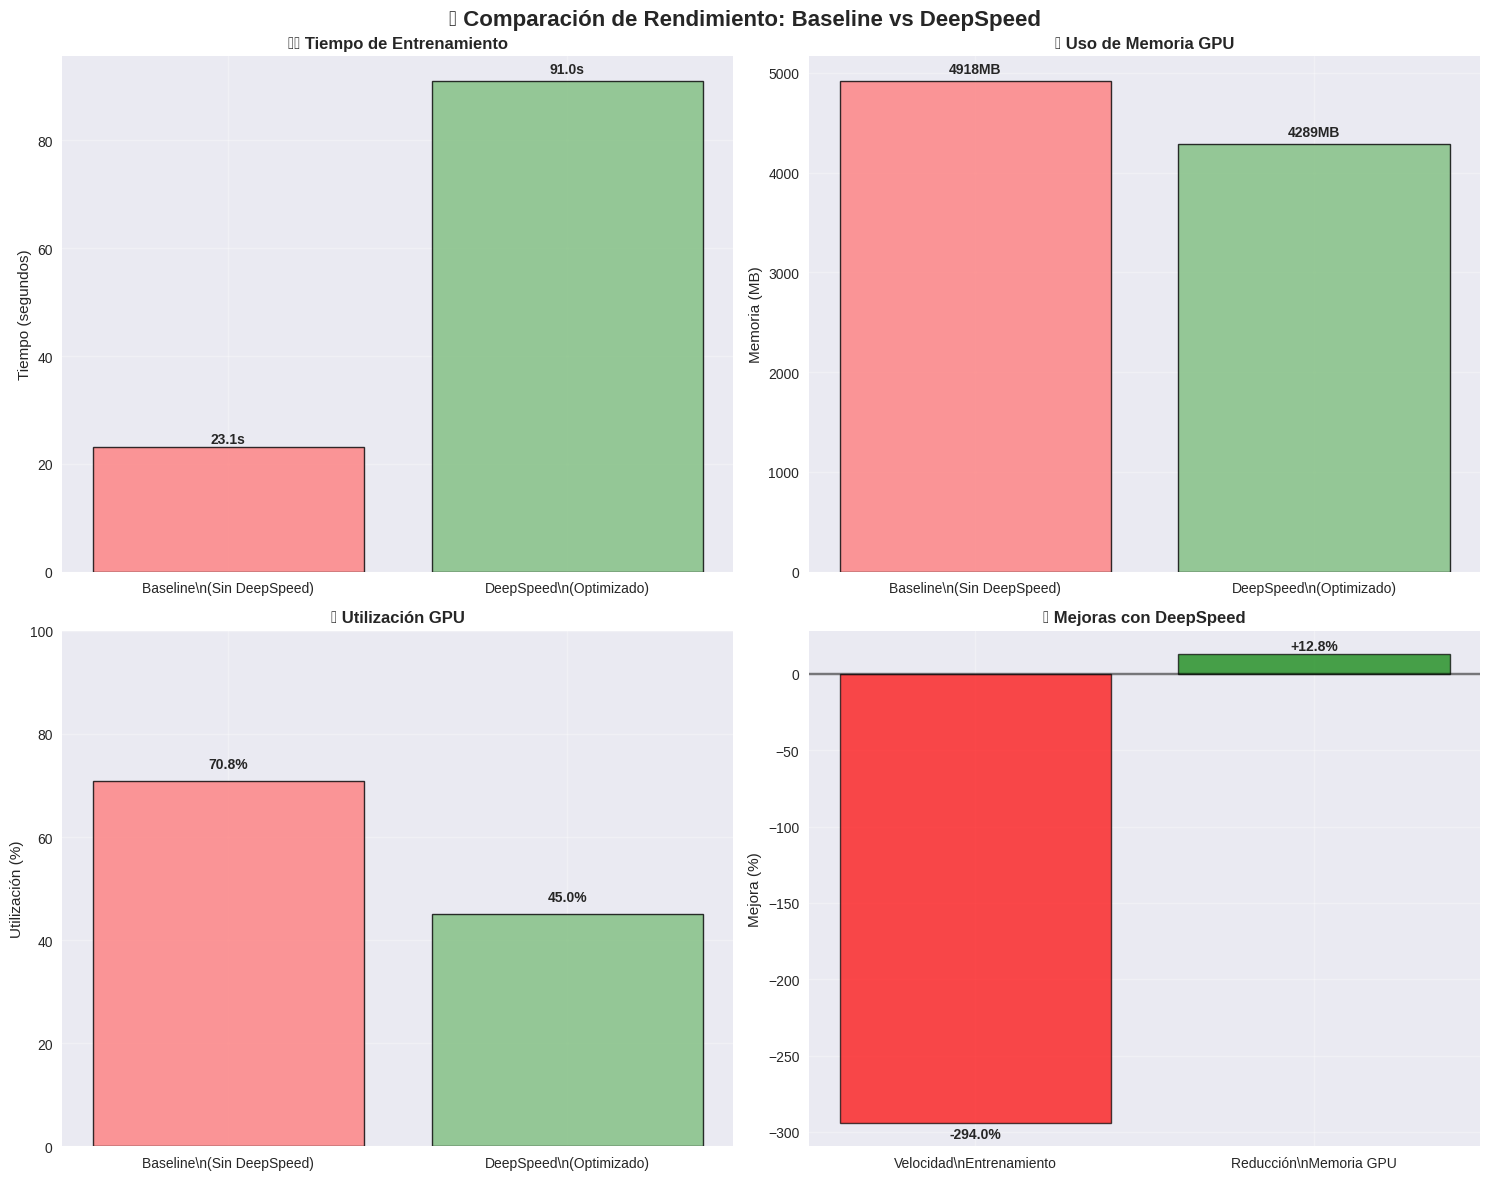

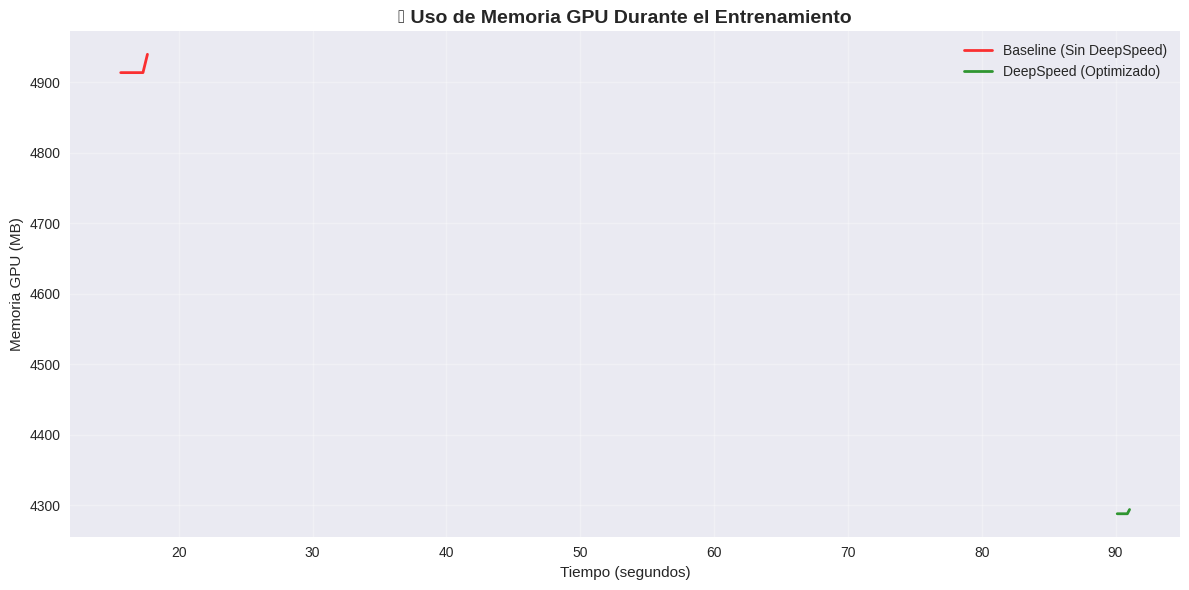

In [19]:
# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🚀 Comparación de Rendimiento: Baseline vs DeepSpeed', fontsize=16, fontweight='bold')

# 1. Tiempo de entrenamiento
ax1 = axes[0, 0]
methods = ['Baseline\\n(Sin DeepSpeed)', 'DeepSpeed\\n(Optimizado)']
times = [baseline_metrics['total_training_time'], deepspeed_metrics['total_training_time']]
colors = ['#ff7f7f', '#7fbf7f']

bars1 = ax1.bar(methods, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('⏱️ Tiempo de Entrenamiento', fontweight='bold')
ax1.set_ylabel('Tiempo (segundos)')
ax1.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, time in zip(bars1, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

# 2. Memoria GPU
ax2 = axes[0, 1]
memory_usage = [baseline_metrics['avg_gpu_memory'], deepspeed_metrics['avg_gpu_memory']]

bars2 = ax2.bar(methods, memory_usage, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('🎯 Uso de Memoria GPU', fontweight='bold')
ax2.set_ylabel('Memoria (MB)')
ax2.grid(True, alpha=0.3)

for bar, memory in zip(bars2, memory_usage):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{memory:.0f}MB', ha='center', va='bottom', fontweight='bold')

# 3. Utilización GPU
ax3 = axes[1, 0]
gpu_util = [baseline_metrics['avg_gpu_utilization'], deepspeed_metrics['avg_gpu_utilization']]

bars3 = ax3.bar(methods, gpu_util, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax3.set_title('📈 Utilización GPU', fontweight='bold')
ax3.set_ylabel('Utilización (%)')
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)

for bar, util in zip(bars3, gpu_util):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{util:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Gráfico de mejoras
ax4 = axes[1, 1]
improvement_metrics = ['Velocidad\\nEntrenamiento', 'Reducción\\nMemoria GPU']
improvement_values = [improvements['time_speedup'], improvements['memory_reduction']]
improvement_colors = ['green' if x > 0 else 'red' for x in improvement_values]

bars4 = ax4.bar(improvement_metrics, improvement_values, color=improvement_colors, alpha=0.7, edgecolor='black', linewidth=1)
ax4.set_title('🏆 Mejoras con DeepSpeed', fontweight='bold')
ax4.set_ylabel('Mejora (%)')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3)

for bar, improvement in zip(bars4, improvement_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
             f'{improvement:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Gráfico de línea temporal para memoria GPU
if len(baseline_detailed['timestamps']) > 0 and len(deepspeed_detailed['timestamps']) > 0:
    plt.figure(figsize=(12, 6))

    plt.plot(baseline_detailed['timestamps'], baseline_detailed['gpu_memory_used'],
             label='Baseline (Sin DeepSpeed)', color='red', linewidth=2, alpha=0.8)
    plt.plot(deepspeed_detailed['timestamps'], deepspeed_detailed['gpu_memory_used'],
             label='DeepSpeed (Optimizado)', color='green', linewidth=2, alpha=0.8)

    plt.title('📈 Uso de Memoria GPU Durante el Entrenamiento', fontsize=14, fontweight='bold')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Memoria GPU (MB)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
